In [1]:
import os
from pyspark import SparkConf, SparkContext

os.environ['PYSPARK_PYTHON']='/home/hadoop/anaconda3/envs/word/bin/python'


import jieba
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
import numpy as np
from PIL import Image
from pyecharts.render import make_snapshot
from snapshot_selenium import snapshot
from pyecharts import options as opts
from pyecharts.charts import Pie, Line, Bar, Funnel, Scatter

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
# 配置spark
  
conf = SparkConf().setMaster("local").setAppName("lab2")

sc = SparkContext(conf=conf)
# sc.stop()
# sc = SparkContext(conf=conf)

# 读取停用词文件
stopWords_filePath = "src/stop_words.txt"
with open(stopWords_filePath, "r", encoding="utf-8") as file:
    stopWords = [line.strip() for line in file.readlines()]

# 读取文本内容并进行分词
data_filePath = "src/data.txt"
dataRdd = sc.textFile(data_filePath)
text = dataRdd.reduce(lambda a, b: a + " " + b)
words_list = jieba.lcut(text)
print(len(words_list))

# 创建RDD并进行词频统计
wordsRdd = sc.parallelize(words_list)
resRdd = wordsRdd.filter(lambda word: word not in stopWords) \
                 .filter(lambda word: len(word) > 1) \
                 .map(lambda word: (word, 1)) \
                 .reduceByKey(lambda a, b: a + b) \
                 .sortBy(lambda x: x[1], ascending=False)
print(resRdd.take(10)) 


Building prefix dict from the default dictionary ...                            
Loading model from cache /tmp/jieba.cache
Loading model cost 0.579 seconds.
Prefix dict has been built successfully.


1375814


[('身高', 2627), ('家庭', 2018), ('父母', 2002), ('性格', 1882), ('男生', 1640), ('朋友', 1618), ('条件', 1568), ('学历', 1445), ('女生', 1380), ('感情', 1301)]


<class 'pyspark.rdd.PipelinedRDD'>


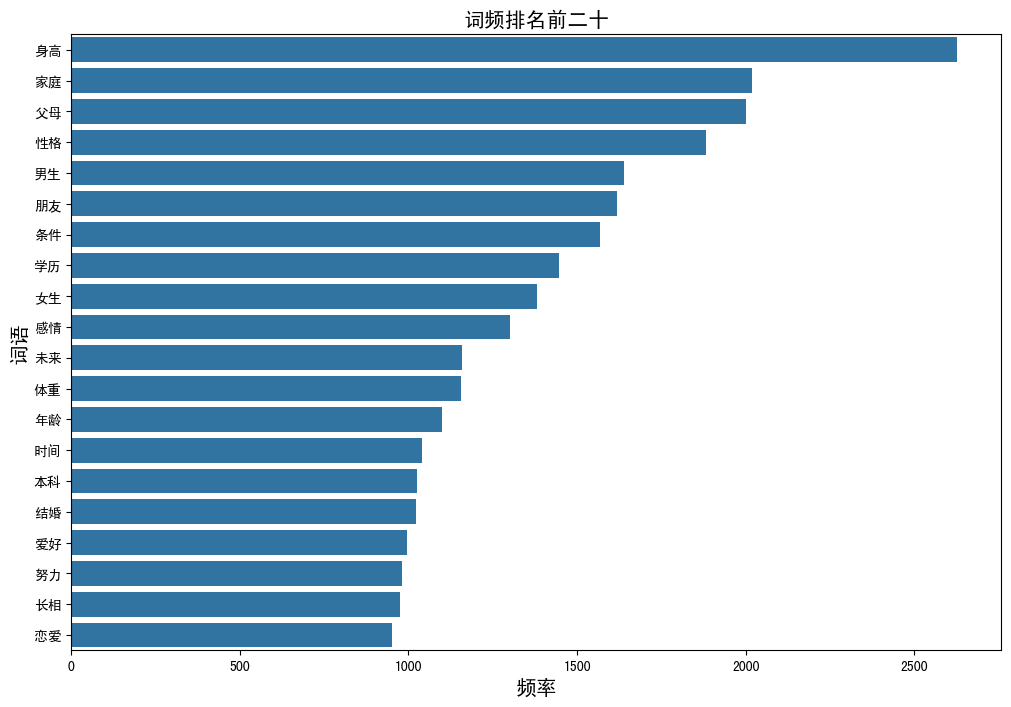

In [3]:
# 设置中文字体
font_name = "SimHei"
plt.rcParams['font.family']= font_name # 指定字体，实际上相当于修改 matplotlibrc 文件　只不过这样做是暂时的　下次失效
plt.rcParams['axes.unicode_minus']=False # 正确显示负号，防止变成方框

print(type(resRdd))

# 绘制词频直方图，展示前20个词语的词频分布
top20 = resRdd.take(20)
words, frequencies = zip(*top20)
plt.figure(figsize=(12, 8))
sns.barplot(y=list(words), x=list(frequencies))
plt.title("词频排名前二十", fontsize=15)
plt.xlabel("频率", fontsize=15)
plt.ylabel("词语", fontsize=15)
plt.show()

In [4]:
import matplotlib
print(matplotlib.matplotlib_fname())

/home/hadoop/anaconda3/envs/word/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


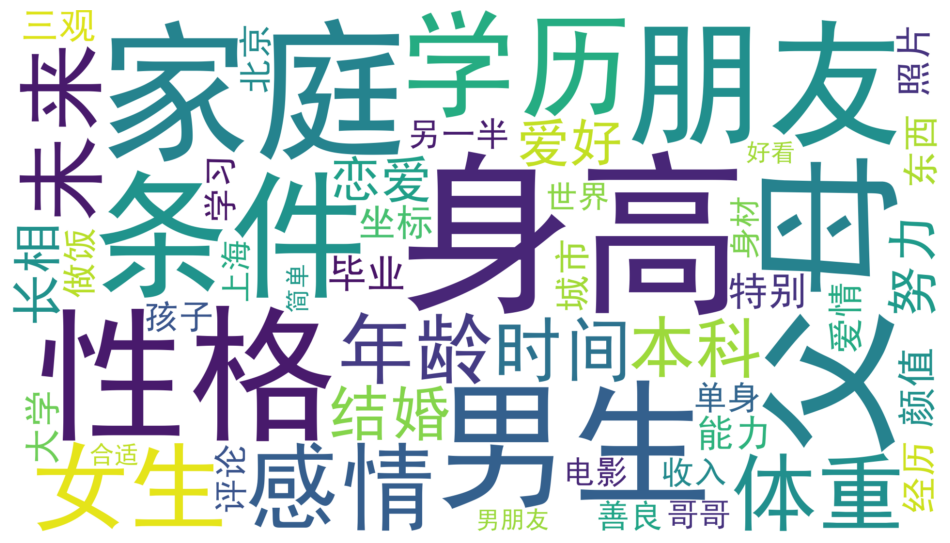

In [5]:
# 词云生成
top50 = resRdd.take(50)
wc = WordCloud(font_path="/home/hadoop/anaconda3/envs/word/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf",
               background_color="white", 
               width=1920, height=1080, 
               max_words=2000, 
               margin=5)
wc.generate_from_frequencies(dict(top50))
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
# 将RDD转换为Dic，并截取指定长度topK
def rdd2dic(resRdd,topK):
        """
        将RDD转换为Dic，并截取指定长度topK
        :param resRdd: 词频统计降序排序结果RDD
        :param topK: 截取的指定长度
        :return:
        """
        # 提示：SparkRdd有函数可直接转换
        resDic = resRdd.collectAsMap()
        # 截取字典前K个
        K = 0
        wordDicK = {}
        for key, value in resDic.items():
            # 完成循环截取字典
            if K >= topK:
                break
            wordDicK[key] = value
            K += 1
        return wordDicK

In [7]:
SAVAPATH = '/home/hadoop/ex2/Lab2_WordCount/results/'

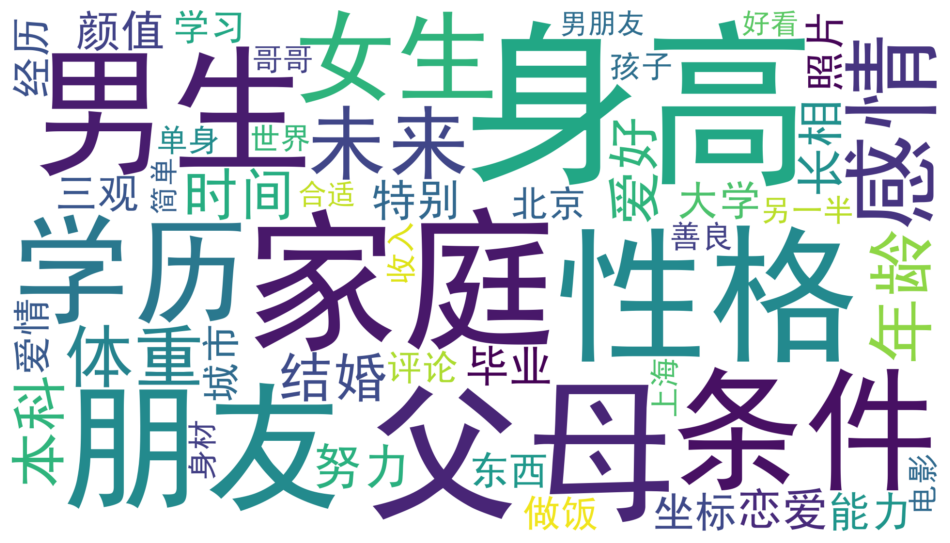

In [8]:
# 生成词云
wwDic = rdd2dic(resRdd,50)
wc = WordCloud(font_path='/home/hadoop/anaconda3/envs/word/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf',
                       background_color='white',
                       max_words=2000,
                       width=1920, height=1080,
                       margin=5)
wc.generate_from_frequencies(wwDic)
plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
if not os.path.exists(SAVAPATH):
            os.makedirs(SAVAPATH)
wc.to_file(os.path.join(SAVAPATH, '词云可视化.png'))


In [9]:
import matplotlib.image as mpimg

在此之前需要安装“WenQuanYi Zen Hei”字体，命令：sudo apt-get install fonts-wqy-zenhei（ubuntu）

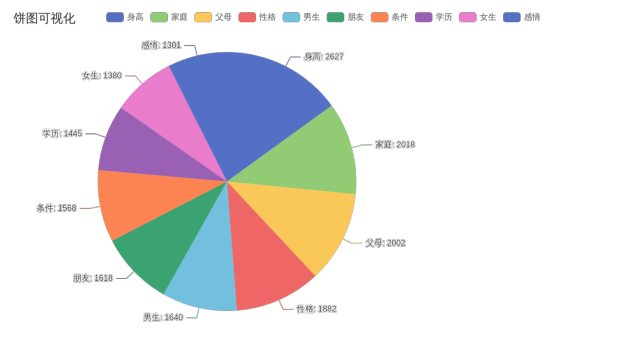

In [10]:
# 饼图可视化

pieDic = rdd2dic(resRdd,10)
key_list = pieDic.keys()      # wordDic所有key组成list
value_list= pieDic.values()   # wordDic所有value组成list
def pie_position() -> Pie:
    c = (
        Pie()
            .add
            (
            "",
            [list(z) for z in zip(key_list, value_list)], # dic -> list
            center=["35%", "50%"],
            )
            .set_global_opts
            (
            title_opts=opts.TitleOpts(
                title='饼图可视化',
                title_textstyle_opts=opts.TextStyleOpts(font_size=18, font_family="WenQuanYi Zen Hei", color="#333")
                ), # 设置标题
            legend_opts=opts.LegendOpts(
                pos_left="15%",
                textstyle_opts=opts.TextStyleOpts(font_size=12, color="#666")  # 设置图例字体
                ),
            )
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
    )
    return c

image_path = SAVAPATH + '饼图可视化.png'

# 保存结果
make_snapshot(snapshot, pie_position().render(), image_path)
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # 不显示坐标轴
plt.show()

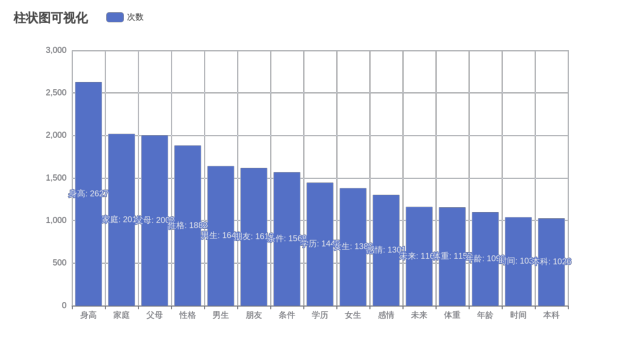

In [12]:
# 柱状图可视化
Dic = rdd2dic(resRdd,15)

key_list = Dic.keys()      # wordDic所有key组成list
value_list= Dic.values()   # wordDic所有value组成list
def bar_position() -> Bar:
    bar = (
        Bar()
            .add_xaxis(list(key_list))
            .add_yaxis("次数", list(value_list))
            .set_global_opts
            (
            title_opts=opts.TitleOpts(title='柱状图可视化'), # 设置标题
            legend_opts=opts.LegendOpts(pos_left="15%"),
            )
            .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
        )
    return bar
# 保存结果

image_path = SAVAPATH + '柱状图可视化.png'
make_snapshot(snapshot, bar_position().render(), image_path)

img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # 不显示坐标轴
plt.show()

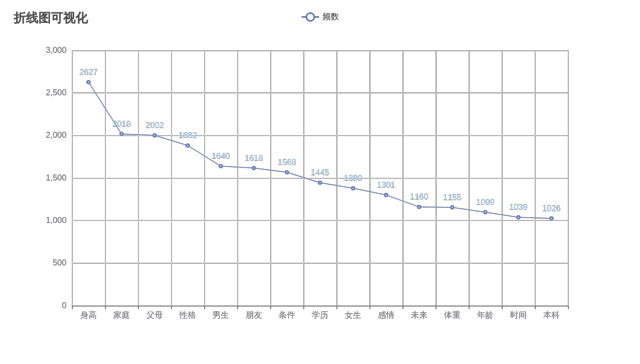

In [13]:
# 折线图可视化
Dic = rdd2dic(resRdd,15)

key_list = Dic.keys()      # wordDic所有key组成list
value_list= Dic.values()   # wordDic所有value组成list
def line_position() -> Line:
    c = (
        Line()
            .add_xaxis(list(key_list))
            .add_yaxis("频数", list(value_list))
            .set_global_opts
            (
            title_opts=opts.TitleOpts(title='折线图可视化'), # 设置标题
            )
            .set_series_opts(label_opts=opts.LabelOpts(color='#99ccff'))
        )
    return c
# 保存结果

image_path = SAVAPATH + '折线图可视化.png'
make_snapshot(snapshot, line_position().render(), image_path)

img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # 不显示坐标轴
plt.show()

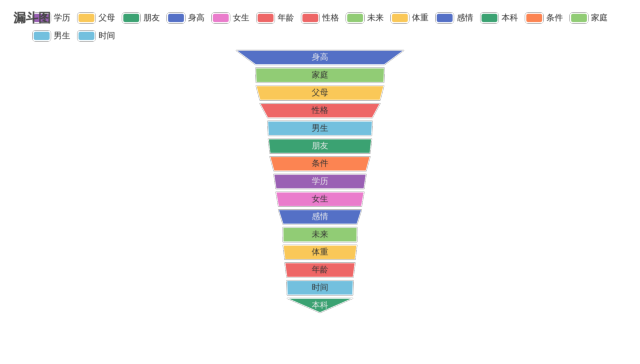

In [14]:
# 漏斗图可视化
from pyecharts.commons.utils import JsCode

sumC = 15

Dic = rdd2dic(resRdd,sumC)

key_list = list(Dic.keys())      # wordDic所有key组成list
value_list= list(Dic.values())   # wordDic所有value组成list

# print(key_list[:5])
# print(value_list[:5])
total_value = sum(value_list[:sumC])
data = [[key_list[i],value_list[i]/80]for i in range(len(key_list))]

# print(data[:5])
def funnel_position() -> Funnel:
    funnel = (
        Funnel()
            .add(
                series_name="",
                data_pair=data,
                gap=5,
                tooltip_opts=opts.TooltipOpts(trigger="item", 
                                              formatter=JsCode("function(params) { return params.seriesName + '<br/>' + params.name + ' : ' + (params.value * 80).toFixed(2); }")),
                label_opts=opts.LabelOpts(is_show=True, position="inside"),
                itemstyle_opts=opts.ItemStyleOpts(border_color="#fff", border_width=1),
            )
            .set_global_opts(title_opts=opts.TitleOpts(title="漏斗图"))
    )
    return funnel
# 保存结果

image_path = SAVAPATH + '漏斗图可视化.png'
make_snapshot(snapshot, funnel_position().render(), image_path)

img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # 不显示坐标轴
plt.show()

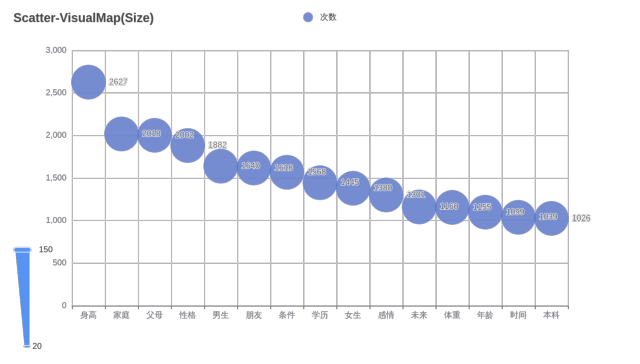

In [15]:
# 散点图可视化

Dic = rdd2dic(resRdd,15)

key_list = list(Dic.keys())      # wordDic所有key组成list
value_list= list(Dic.values())   # wordDic所有value组成list
def scatter_position() -> Funnel:
    scatter = (
        Scatter()
            .add_xaxis(key_list)
            .add_yaxis("次数", value_list)
            .set_global_opts(
                title_opts=opts.TitleOpts(title="Scatter-VisualMap(Size)"),
                visualmap_opts=opts.VisualMapOpts(type_="size", max_=150, min_=20),
        )
    )
    return scatter
# 保存结果
image_path = SAVAPATH + '散点图可视化.png'
make_snapshot(snapshot, scatter_position().render(), image_path)

img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # 不显示坐标轴
plt.show()
